In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#109747'
NONTARGET_COLOR = 'black'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
# animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [3]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 2\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

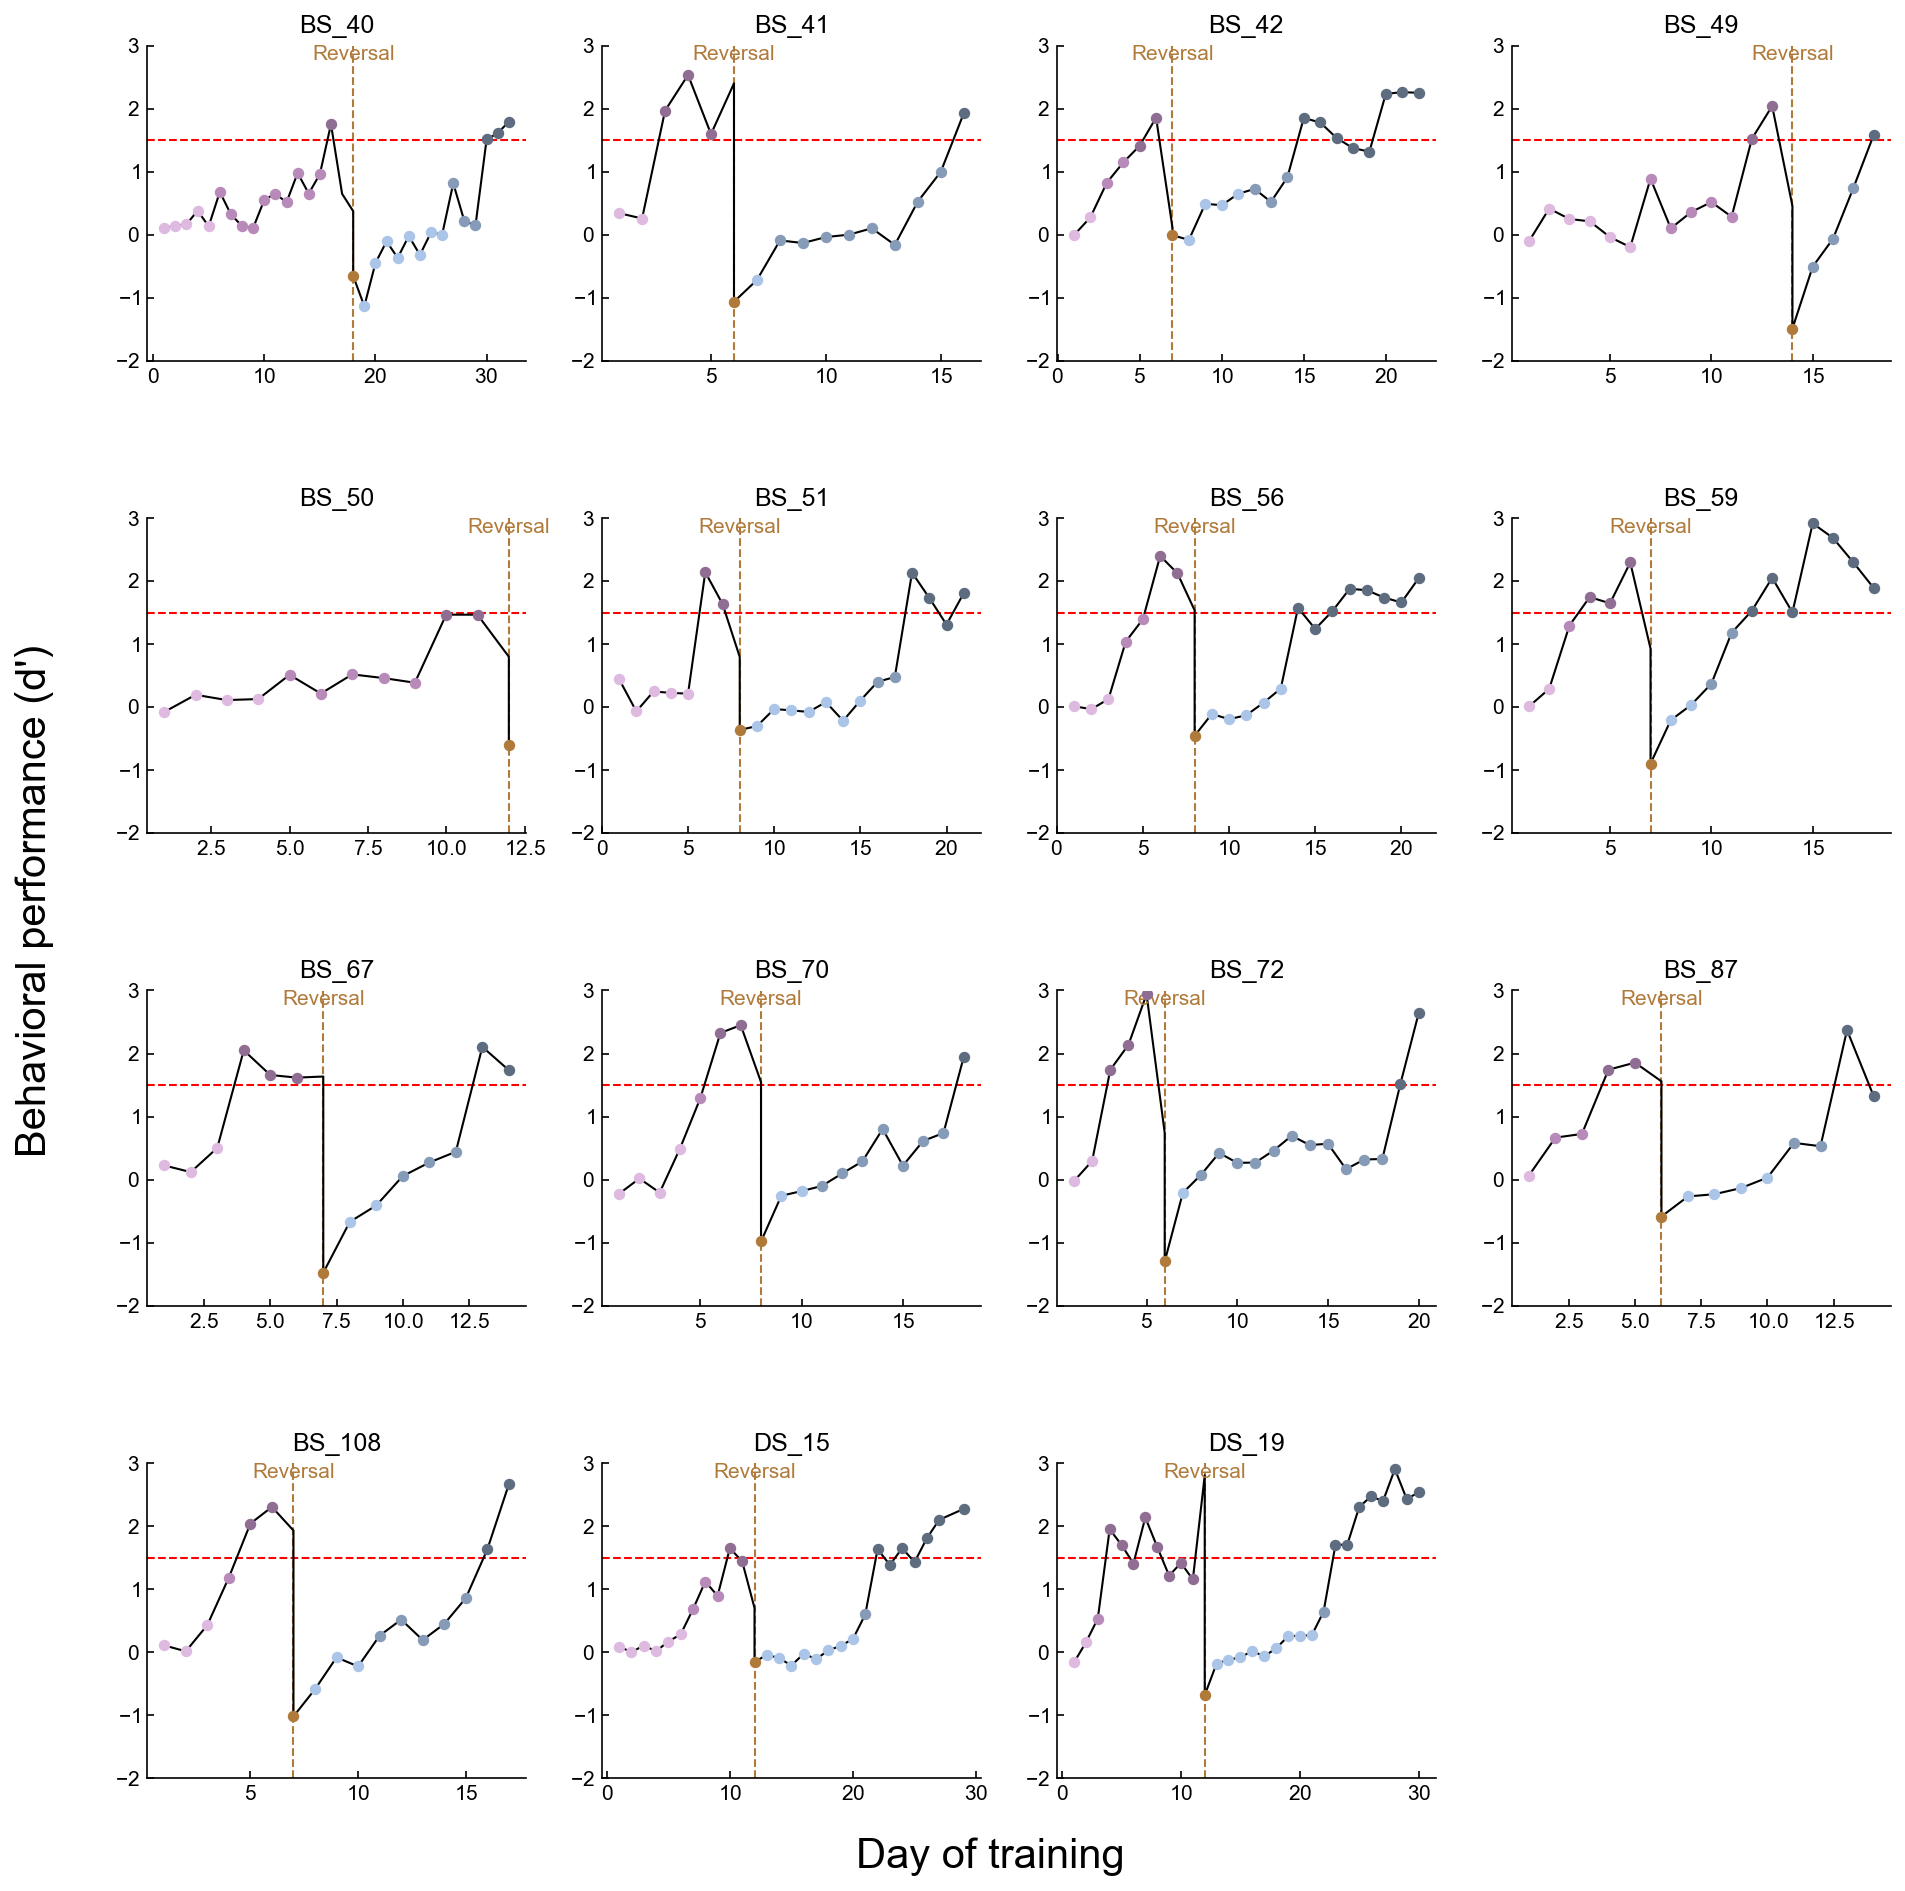

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
    # EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:32<00:00, 22.54it/s]


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:45<00:00, 40.32it/s]

errors for: []


In [8]:
cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
cluster_ID_list = []
learning_phase_list = []
go_firing_list = []
nogo_firing_list = []
target_go_firing_list = []
target_nogo_firing_list = []
nontarget_go_firing_list = []
nontarget_nogo_firing_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)

    # if sessionfile.responsiveness[clust]['all_trials'].FRmodulation < 3.5:
    #     continue
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod_go = sessionfile.responsiveness[clust]['go'].FRmodulation
        FRmod_nogo = sessionfile.responsiveness[clust]['nogo'].FRmodulation
        target_FRmod_go = sessionfile.responsiveness[clust]['hit'].FRmodulation
        target_FRmod_nogo = sessionfile.responsiveness[clust]['miss'].FRmodulation
        nontarget_FRmod_go = sessionfile.responsiveness[clust]['falarm'].FRmodulation
        nontarget_FRmod_nogo = sessionfile.responsiveness[clust]['creject'].FRmodulation
    except Exception as e:
        print(e)
        continue

    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    cluster_ID_list.append(clust)
    learning_phase_list.append(EILphases[idx])
    go_firing_list.append(FRmod_go)
    nogo_firing_list.append(FRmod_nogo)
    target_go_firing_list.append(target_FRmod_go)
    target_nogo_firing_list.append(target_FRmod_nogo)
    nontarget_go_firing_list.append(nontarget_FRmod_go)
    nontarget_nogo_firing_list.append(nontarget_FRmod_nogo)

1829it [00:45, 40.05it/s] 


In [9]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['cluster ID'] = cluster_ID_list
df_dict['learning phase'] = learning_phase_list
df_dict['go FR modulation'] = go_firing_list
df_dict['nogo FR modulation'] = nogo_firing_list
df_dict['hit FR modulation'] = target_go_firing_list
df_dict['miss FR modulation'] = target_nogo_firing_list
df_dict['false alarm FR modulation'] = nontarget_go_firing_list
df_dict['correct reject FR modulation'] = nontarget_nogo_firing_list
df = pd.DataFrame(df_dict)

In [10]:
df

,animal,session,cluster ID,learning phase,go FR modulation,nogo FR modulation,hit FR modulation,miss FR modulation,false alarm FR modulation,correct reject FR modulation
0,BS_108,BS_108_1_AC.pickle,2,pre expert,13.409091,3.232323,17.096774,0.000000,4.615385,3.333333
1,BS_108,BS_108_1_AC.pickle,8,pre expert,25.692884,11.809524,31.746032,20.000000,11.025641,12.745098
2,BS_108,BS_108_1_AC.pickle,9,pre expert,19.101124,8.571429,24.338624,46.666667,9.743590,8.627451
3,BS_108,BS_108_1_AC.pickle,14,pre expert,12.878788,5.858586,18.709677,6.666667,1.794872,6.250000
4,BS_108,BS_108_1_AC.pickle,34,pre expert,19.700375,10.095238,25.925926,86.666667,6.923077,9.019608
...,...,...,...,...,...,...,...,...,...,...
1358,DS_19,DS_19_1_AC.pickle,96,pre expert,2.752525,3.034826,4.117647,6.262626,2.411348,1.980198
1359,DS_19,DS_19_1_AC.pickle,106,pre expert,1.897628,1.709402,2.042389,1.428571,3.546099,2.690058
1360,DS_19,DS_19_20_AC.pickle,7,post expert,6.865672,3.954802,10.069444,NaN,2.807018,3.954802
1361,DS_19,DS_19_20_AC.pickle,8,post expert,2.437811,3.841808,2.986111,NaN,2.105263,3.841808


C:\Users\4thgr\AppData\Local\Temp\ipykernel_10968\3124510501.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
C:\Users\4thgr\AppData\Local\Temp\ipykernel_10968\3124510501.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)


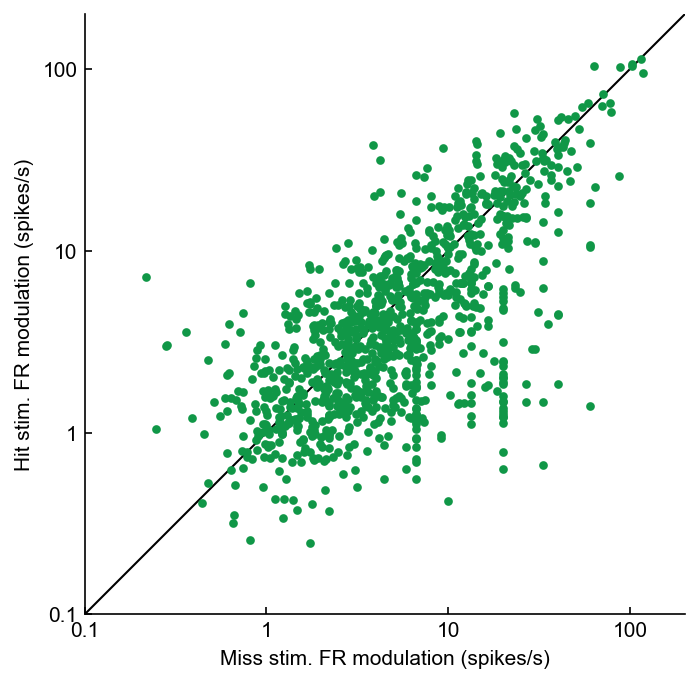

In [11]:
go_FR = df['hit FR modulation']
nogo_FR = df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
ax.set_xlim([0.1,200])
ax.set_ylim([0.1,200])
ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.1,1,10,100])
ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0.1','1','10','100'])

ax.scatter(nogo_FR,go_FR,s=10,c=TARGET_COLOR)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
lims[0] = 0
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xlabel('Miss stim. FR modulation (spikes/s)')
ax.set_ylabel('Hit stim. FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

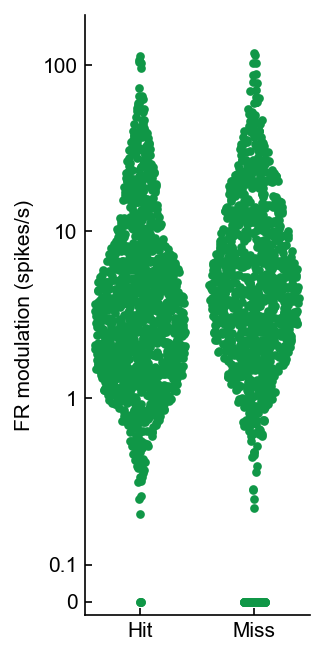

In [30]:
go_FR = df['hit FR modulation']
nogo_FR = df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary Violin V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

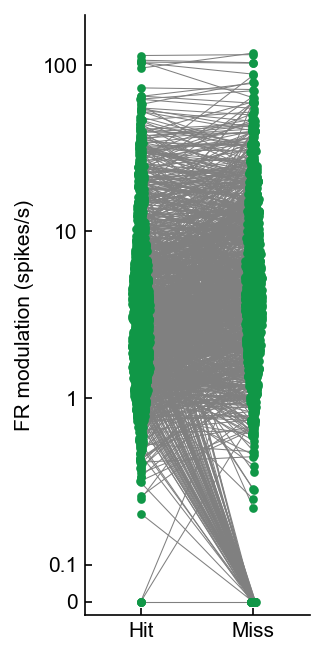

In [29]:
go_FR = df['hit FR modulation']
nogo_FR = df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X1,Y1 = ilep.violin(go_FR,log=True,logzeroval=0.06,width=0.2)
ax.scatter(X1,Y1,s=10,c=TARGET_COLOR)

X2,Y2 = ilep.violin(nogo_FR,log=True,logzeroval=0.06,width=0.2)
ax.scatter(X2+1,Y2,s=10,c=TARGET_COLOR)

ax.plot([X1,X2+1],[Y1,Y2],c='grey',lw=0.5,zorder=-10)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xlim([-0.5,1.5])

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary connected Violin V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [13]:
X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=294073.5, pvalue=4.3303054281951366e-06)

In [14]:
# plt.hist(Y-X,bins=100)
print(np.median(Y-X))
print(np.mean(Y-X))

-0.25683322730021274
-1.1400039636896764


C:\Users\4thgr\AppData\Local\Temp\ipykernel_10968\2315379342.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
C:\Users\4thgr\AppData\Local\Temp\ipykernel_10968\2315379342.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)


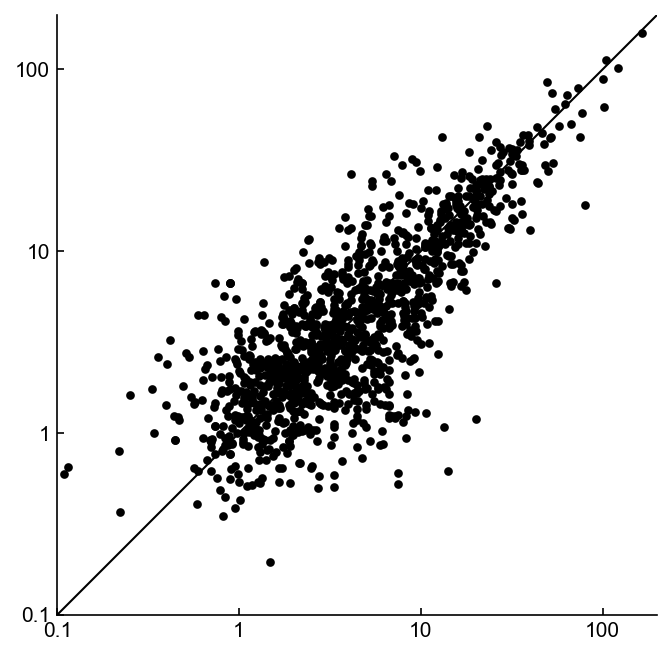

In [24]:
go_FR = df['false alarm FR modulation']
nogo_FR = df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
ax.set_xlim([0.1,200])
ax.set_ylim([0.1,200])
ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.1,1,10,100])
ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0.1','1','10','100'])

ax.scatter(nogo_FR,go_FR,s=10,c=NONTARGET_COLOR)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
lims[0] = 0
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.plot(lims,lims,c='k',zorder=-10,lw=1)

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

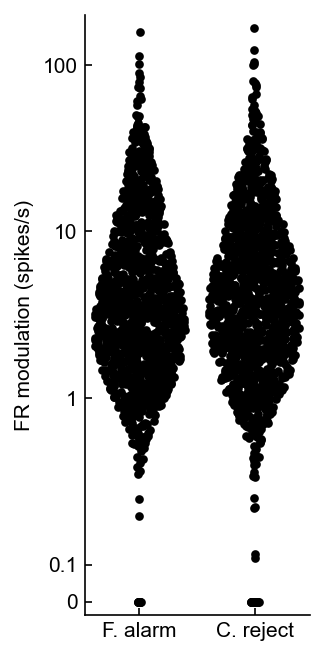

In [31]:
go_FR = df['false alarm FR modulation']
nogo_FR = df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary Violin V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

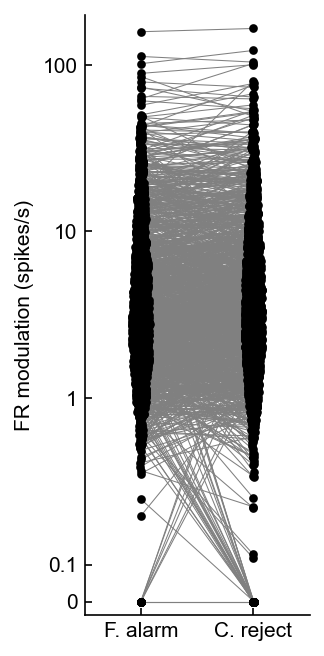

In [32]:
go_FR = df['false alarm FR modulation']
nogo_FR = df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X1,Y1 = ilep.violin(go_FR,log=True,logzeroval=0.06,width=0.2)
ax.scatter(X1,Y1,s=10,c=NONTARGET_COLOR)

X2,Y2 = ilep.violin(nogo_FR,log=True,logzeroval=0.06,width=0.2)
ax.scatter(X2+1,Y2,s=10,c=NONTARGET_COLOR)

ax.plot([X1,X2+1],[Y1,Y2],c='grey',lw=0.5,zorder=-10)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xlim([-0.5,1.5])

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary connected Violin V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [27]:
X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=379914.5, pvalue=0.03708150987277226)

In [28]:
# plt.hist(Y-X,bins=100)
print(np.median(Y-X))
print(np.mean(Y-X))

-0.07978949155419746
-0.26246912043516446


In [35]:
X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=400430.0, pvalue=0.024584716443798418)

-0.13988480075232168
-0.19559285108509475


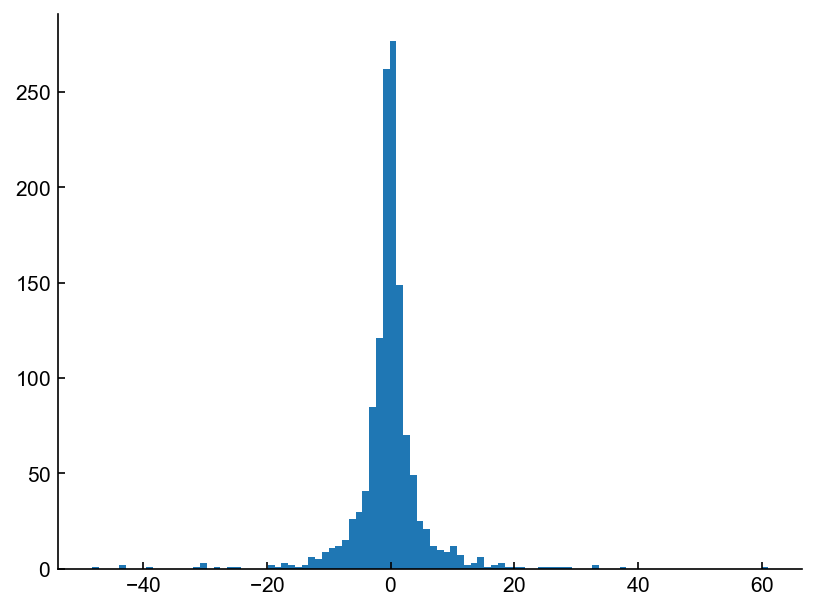

In [32]:
plt.hist(Y-X,bins=100)
print(np.median(Y-X))
print(np.mean(Y-X))

# Break out by phase

WilcoxonResult(statistic=3951.0, pvalue=0.004009014747809355)

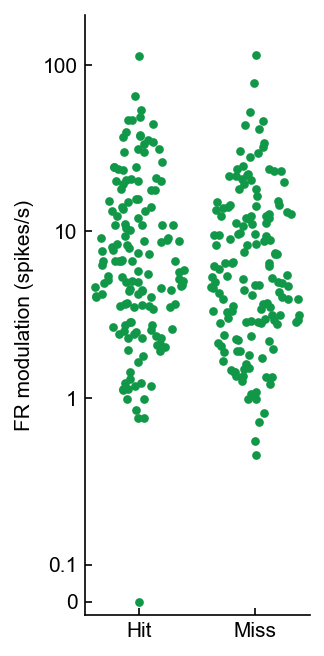

In [39]:
subset_df = df[df['learning phase'] == 'pre early']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary pre early V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=7872.0, pvalue=0.5230803331272383)

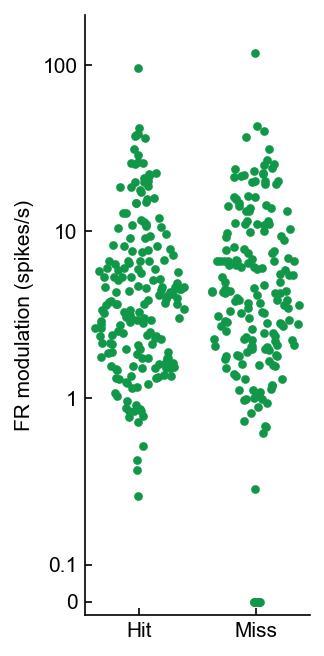

In [40]:
subset_df = df[df['learning phase'] == 'pre late']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary pre late V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=1714.5, pvalue=0.23867712322548396)

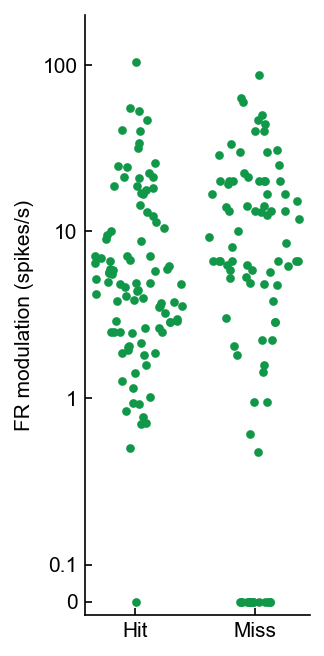

In [41]:
subset_df = df[df['learning phase'] == 'pre expert']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary pre expert V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=16859.0, pvalue=0.00014401731413956186)

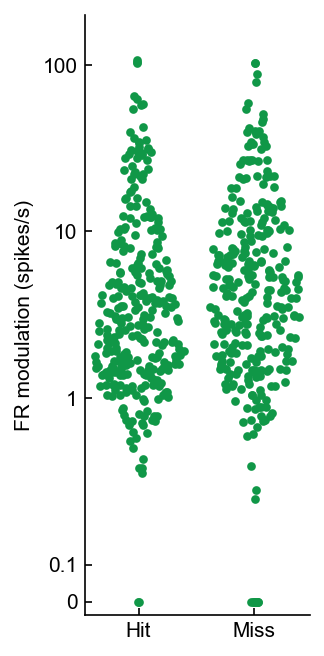

In [42]:
subset_df = df[df['learning phase'] == 'post early']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary post early V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=15207.0, pvalue=9.595754684104824e-07)

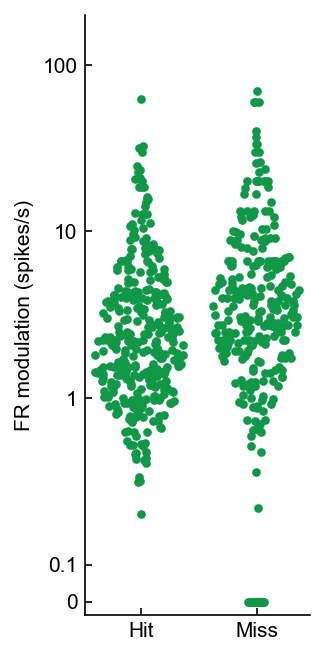

In [43]:
subset_df = df[df['learning phase'] == 'post late']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary post late V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=5091.0, pvalue=0.015831269132422936)

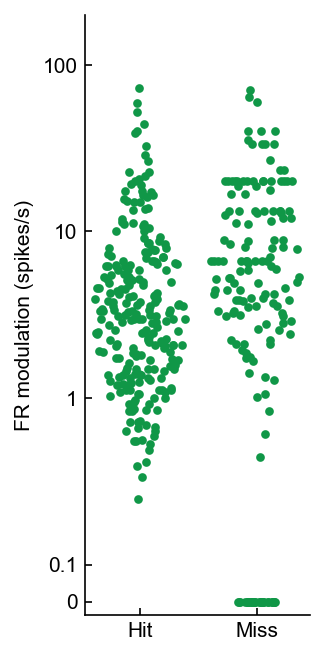

In [44]:
subset_df = df[df['learning phase'] == 'post expert']
go_FR = subset_df['hit FR modulation']
nogo_FR = subset_df['miss FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=TARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=TARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['Hit','Miss'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','Hit vs Miss Summary post expert V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=4943.0, pvalue=0.27521329494514357)

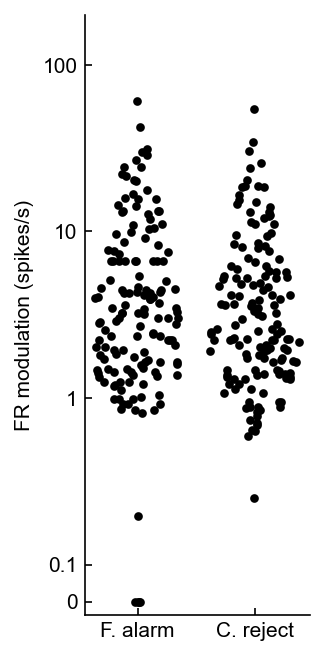

In [46]:
subset_df = df[df['learning phase'] == 'pre early']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary pre early V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=8286.0, pvalue=0.9546206000808699)

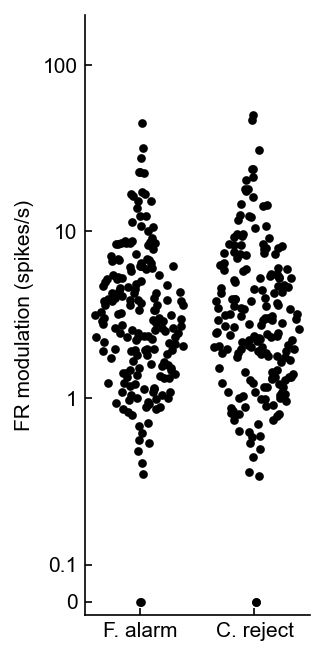

In [47]:
subset_df = df[df['learning phase'] == 'pre late']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary pre late V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=1351.0, pvalue=0.14505759376051802)

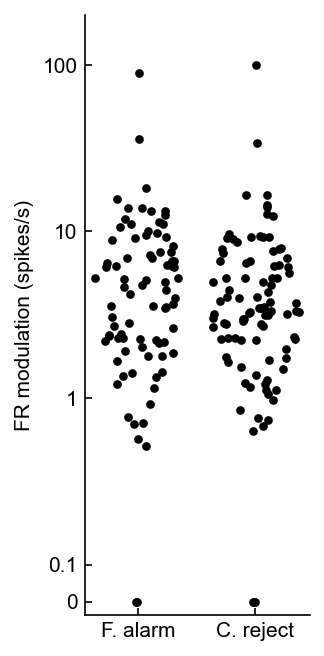

In [48]:
subset_df = df[df['learning phase'] == 'pre expert']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary pre expert V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=17500.0, pvalue=0.0013380156012167614)

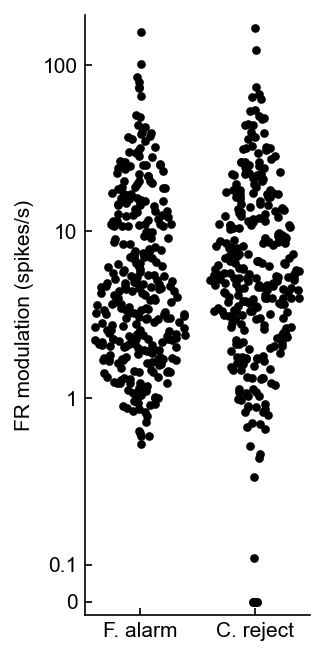

In [49]:
subset_df = df[df['learning phase'] == 'post early']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary post early V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=22704.0, pvalue=0.0037120128768181565)

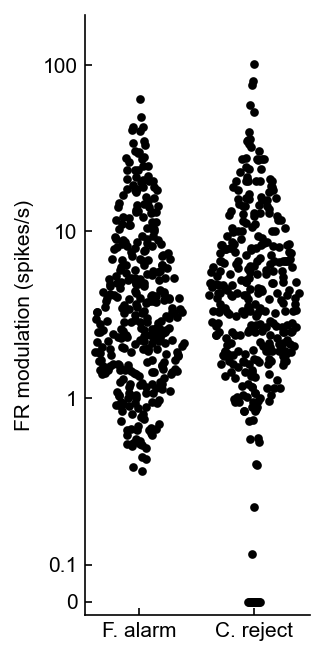

In [50]:
subset_df = df[df['learning phase'] == 'post late']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary post late V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)

WilcoxonResult(statistic=12709.0, pvalue=0.31643703433606274)

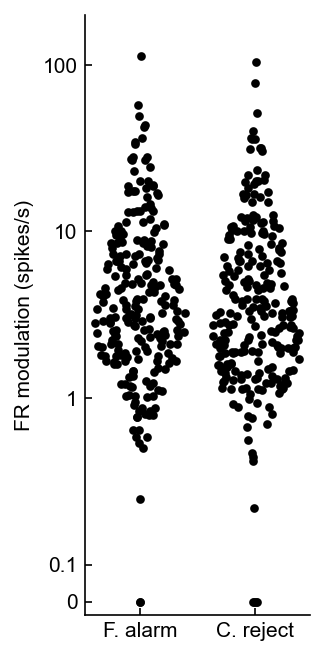

In [51]:
subset_df = df[df['learning phase'] == 'post expert']
go_FR = subset_df['false alarm FR modulation']
nogo_FR = subset_df['correct reject FR modulation']

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
# ax.set_xscale('log',subs=[])
ax.set_yscale('log',subs=[])
# ax.set_xlim([0.1,200])
ax.set_ylim([0.05,200])
# ax.set_xticks([0.1,1,10,100])
ax.set_yticks([0.06,0.1,1,10,100])
# ax.set_xticklabels(['0.1','1','10','100'])
ax.set_yticklabels(['0','0.1','1','10','100'])

X,Y = ilep.violin(go_FR,log=True,logzeroval=0.06)
ax.scatter(X,Y,s=10,c=NONTARGET_COLOR)

X,Y = ilep.violin(nogo_FR,log=True,logzeroval=0.06)
ax.scatter(X+1,Y,s=10,c=NONTARGET_COLOR)

# ylim = ax.get_ylim()
# xlim = ax.get_xlim()
# lims = [min(xlim[0],ylim[0]),max(xlim[1],ylim[1])]
# lims[0] = 0
# ax.set_xlim(lims)
# ax.set_ylim(lims)

# ax.plot(lims,lims,c='k',zorder=-10,lw=1)

ax.set_xticks([0,1])
ax.set_xticklabels(['F. alarm','C. reject'])
ax.set_ylabel('FR modulation (spikes/s)')

artists = []
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','falarm vs creject Summary post expert V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

X,Y = ilep.paired_rmnan(nogo_FR,go_FR)
wilcoxon(X,Y)